## Tests for the implementation of the multi-$Q^2$ kernel evolution

The return state of the dglap evolution should be a matrix not only in $x$ and flavour (as it is the case at the moment) but also on $Q^2$.

The goals are:

1. Minimize the amount of numba compilation. i.e., make sure we don't repeat calculations.
2. Parallelize the computation of the different values of $Q^2$ on the CPU.

Extra for the future:
- Compile the numba code into a GPU so the grid of $Q^2$ is computed on a GPU.

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import numpy as np
import json
import eko.dglap as dglap
import eko.interpolation as interpolation
save_json = False
nqs = 10

In [21]:
# Compute the input parameters
xgrid_low = interpolation.get_xgrid_linear_at_log(35,1e-7,0.1)
xgrid_mid = interpolation.get_xgrid_linear_at_id(15,0.1,0.95)
xgrid_high = 1.0-interpolation.get_xgrid_linear_at_log(5,1e-3,1.0 - 0.95)
xgrid = np.unique(np.concatenate((xgrid_low,xgrid_mid,xgrid_high)))
toy_xgrid = np.array([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,.1,.3,.5,.7,.9])
polynom_rank = 4
Qref = np.sqrt(2)
Q0 = np.sqrt(2)
nf = 5

In [22]:
%%time
if save_json:
    ret1 = dglap.run_dglap({
        "PTO": 0,
        'alphas': 0.35,
        'Qref': Qref,
        'Q0': Q0,
        'NfFF': nf,

        "xgrid_type": "custom",
        "xgrid": xgrid,
        "xgrid_polynom_rank": polynom_rank,
        "log_interpol": True,
        "targetgrid": toy_xgrid,
        "Q2grid": [1e4]
    })

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 21 µs


In [23]:
#Save/load the operator to/from a json file
if save_json:
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return json.JSONEncoder.default(self, obj)
    f = open('operators.json', 'w')
    json.dump(ret1["operators"], f, cls = NumpyEncoder)
    f.close()
else:
    f = open('operators.json', 'r')
    ret_backup = json.load(f)
    ret1 = {}
    for key, item in ret_backup.items():
        ret1[key] = np.array(item).reshape(len(toy_xgrid), -1, 1)
    f.close()

Check the ret1 we have correspond to the correct thing if we happen to do the benchmark plot

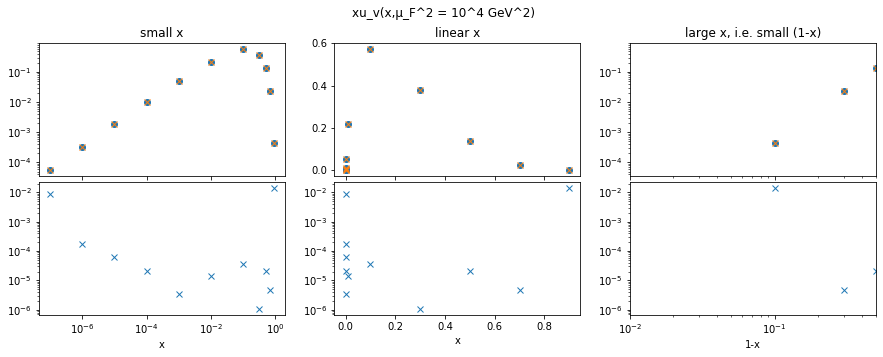

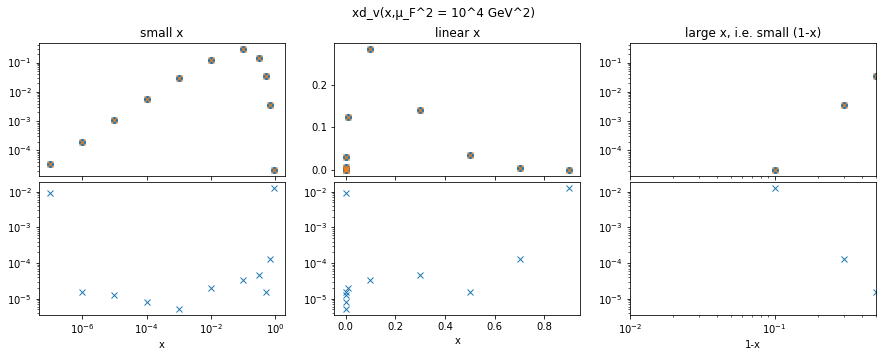

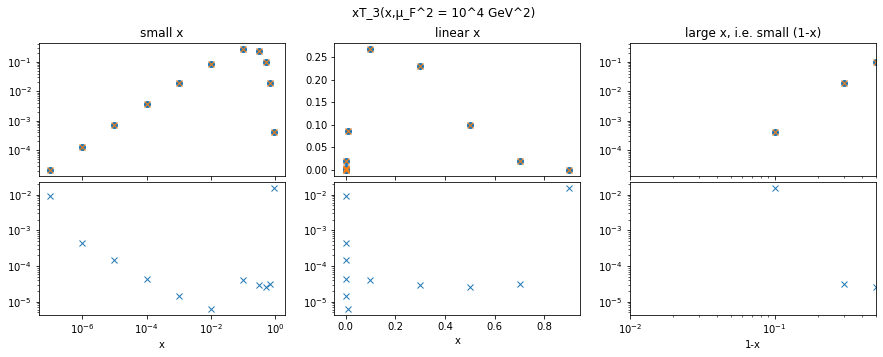

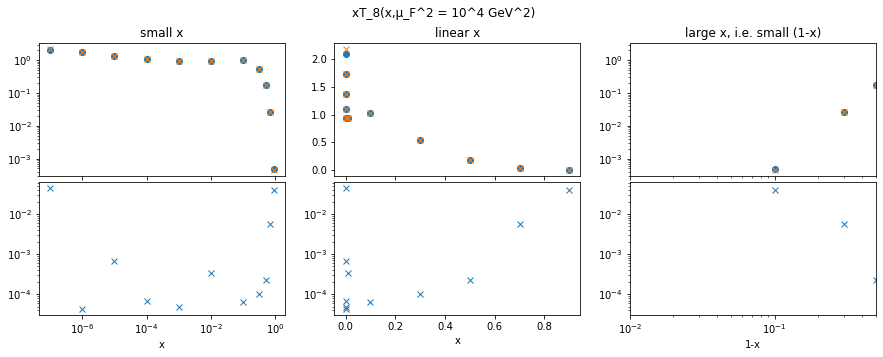

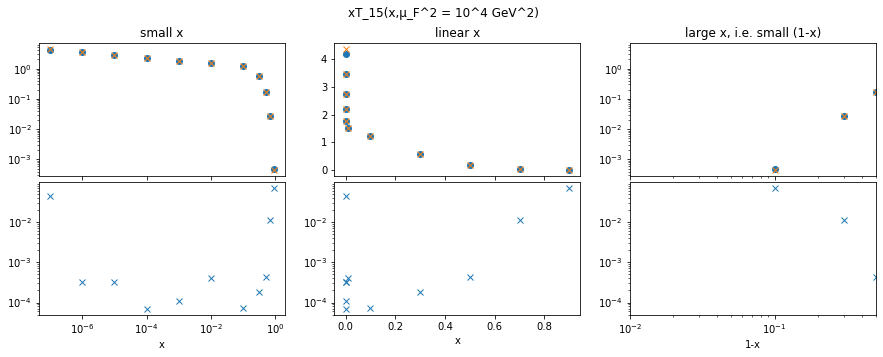

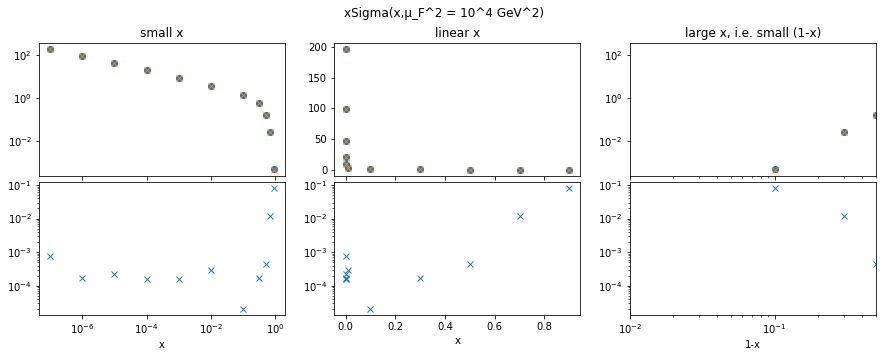

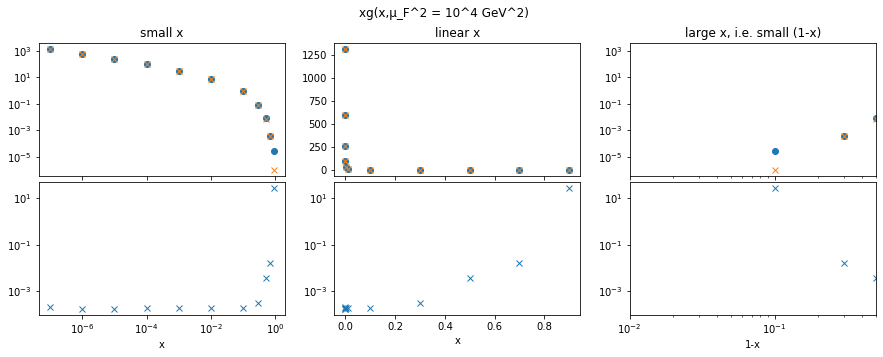

In [25]:
# implement Eq. 31 of arXiv:hep-ph/0204316
import matplotlib.pyplot as plt
import matplotlib
def toy_uv0(x):
    return 5.107200 * x**(0.8) * (1.0 - x)**3 / x
def toy_dv0(x):
    return 3.064320 * x**(0.8) * (1.0 - x)**4 / x
def toy_g0(x):
    return 1.7 * x**(-0.1) * (1.0 - x)**5 / x
def toy_dbar0(x):
    return 0.1939875 *  x**(-0.1) *  (1.0 - x)**6 / x
def toy_ubar0(x):
    return (1.0 - x) * toy_dbar0(x)
def toy_s0(x):
    return 0.2 * (toy_ubar0(x) + toy_dbar0(x))
def toy_sbar0(x):
    return toy_s0(x)
def toy_Lm0(x):
    return toy_dbar0(x) - toy_ubar0(x)
def toy_Lp0(x):
    return (toy_dbar0(x) + toy_ubar0(x))*2.0 # 2 is missing in the paper!
def toy_sp0(x):
    return toy_s0(x) + toy_sbar0(x)
def toy_T30(x):
    return -2.0 * toy_Lm0(x) + toy_uv0(x) - toy_dv0(x)
def toy_T80(x):
    return toy_Lp0(x) + toy_uv0(x) + toy_dv0(x) - 2.0*toy_sp0(x)
def toy_S0(x):
    return toy_uv0(x) + toy_dv0(x) + toy_Lp0(x) + toy_sp0(x)

def plot_dist(x,y,yref,title=None):
    """compare to distributions both in linear and logarithmic x-space"""
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.05)
    if title is not None:
       fig.suptitle(title)
    # small x
    ax1 = plt.subplot(2,3,1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.title("small x")
    plt.loglog(x,y,"o")
    plt.loglog(x,yref,"x")
    plt.subplot(2,3,4,sharex=ax1)
    plt.loglog(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # linear x
    ax2 = plt.subplot(2,3,2)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.title("linear x")
    plt.plot(x,y,"o")
    plt.plot(x,yref,"x")
    plt.subplot(2,3,5,sharex=ax2)
    plt.semilogy(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # large x
    ax3 = plt.subplot(2,3,3)
    oMx = 1.0 - x
    plt.setp(ax3.get_xticklabels(), visible=False)
    oMx_min = 1e-2
    oMx_max = 0.5
    ax3.set_xlim(oMx_min,oMx_max)
    plt.title("large x, i.e. small (1-x)")
    plt.loglog(oMx,y,"o")
    plt.loglog(oMx,yref,"x")
    ax = plt.subplot(2,3,6,sharex=ax3)
    plt.loglog(oMx,np.abs((y - yref)/yref),"x")
    plt.xlabel("1-x")
    return fig

# check table 2 part 2 of arXiv:hep-ph/0204316
def plot_table2_2(ret1):
    toy_uv1_xgrid = np.array([toy_uv0(x) for x in xgrid])
    toy_uv1_grid = np.dot(ret1["NS"][:,:,0],toy_uv1_xgrid)
    toy_xuv1_grid_ref = np.array([5.7722e-5,3.3373e-4,1.8724e-3,1.0057e-2,5.0392e-2,2.1955e-1,5.7267e-1,3.7925e-1,1.3476e-1,2.3123e-2,4.3443e-4])
    plot_dist(toy_xgrid,toy_xgrid*toy_uv1_grid,toy_xuv1_grid_ref,title="xu_v(x,µ_F^2 = 10^4 GeV^2)")

    toy_dv1_xgrid = np.array([toy_dv0(x) for x in xgrid])
    toy_dv1_grid = np.dot(ret1["NS"][:,:,0],toy_dv1_xgrid)
    toy_xdv1_grid_ref = np.array([3.4343e-5,1.9800e-4,1.1065e-3,5.9076e-3,2.9296e-2,1.2433e-1,2.8413e-1,1.4186e-1,3.5364e-2,3.5943e-3,2.2287e-5])
    plot_dist(toy_xgrid,toy_xgrid*toy_dv1_grid,toy_xdv1_grid_ref,title="xd_v(x,µ_F^2 = 10^4 GeV^2)")

    toy_T31_xgrid = np.array([toy_T30(x) for x in xgrid])
    toy_T31_grid = np.dot(ret1["NS"][:,:,0],toy_T31_xgrid)
    toy_xLm1_grid_ref = np.array([7.6527e-7,5.0137e-6,3.1696e-5,1.9071e-4,1.0618e-3,4.9731e-3,1.0470e-2,3.3029e-3,4.2815e-4,1.5868e-5,1.1042e-8])
    toy_xT31_grid_ref = -2.0 * toy_xLm1_grid_ref + toy_xuv1_grid_ref - toy_xdv1_grid_ref
    plot_dist(toy_xgrid,toy_xgrid*toy_T31_grid,toy_xT31_grid_ref,title="xT_3(x,µ_F^2 = 10^4 GeV^2)")

    toy_T81_xgrid = np.array([toy_T80(x) for x in xgrid])
    toy_T81_grid = np.dot(ret1["NS"][:,:,0],toy_T81_xgrid)
    toy_xLp1_grid_ref = np.array([9.9465e+1,5.0259e+1,2.4378e+1,1.1323e+1,5.0324e+0,2.0433e+0,4.0832e-1,4.0165e-2,2.8624e-3,6.8961e-5,3.6293e-8])
    toy_xsp1_grid_ref = np.array([4.8642e+1,2.4263e+1,1.1501e+1,5.1164e+0,2.0918e+0,7.2814e-1,1.1698e-1,1.0516e-2,7.3138e-4,1.7725e-5,1.0192e-8])
    toy_xT81_grid_ref = toy_xLp1_grid_ref + toy_xuv1_grid_ref + toy_xdv1_grid_ref - 2.0 * toy_xsp1_grid_ref
    plot_dist(toy_xgrid,toy_xgrid*toy_T81_grid,toy_xT81_grid_ref,title="xT_8(x,µ_F^2 = 10^4 GeV^2)")

    toy_T151_xgrid = np.array([toy_S0(x) for x in xgrid])
    toy_T151_grid = np.dot(ret1["NS"][:,:,0],toy_T151_xgrid)
    toy_xcp1_grid_ref = np.array([4.7914e+1,2.3685e+1,1.1042e+1,4.7530e+0,1.8089e+0,5.3247e-1,5.8864e-2,4.1379e-3,2.6481e-4,6.5549e-6,4.8893e-9])
    toy_T151_grid_ref = toy_xLp1_grid_ref + toy_xuv1_grid_ref + toy_xdv1_grid_ref + toy_xsp1_grid_ref - 3.0 * toy_xcp1_grid_ref
    plot_dist(toy_xgrid,toy_xgrid*toy_T151_grid,toy_T151_grid_ref,title="xT_15(x,µ_F^2 = 10^4 GeV^2)")

    toy_S1_xgrid = np.array([toy_S0(x) for x in xgrid])
    toy_g1_xgrid = np.array([toy_g0(x) for x in xgrid])
    toy_S1_grid = np.dot(ret1["S_qq"][:,:,0],toy_S1_xgrid) + np.dot(ret1["S_qg"][:,:,0],toy_g1_xgrid)
    toy_g1_grid = np.dot(ret1["S_gq"][:,:,0],toy_S1_xgrid) + np.dot(ret1["S_gg"][:,:,0],toy_g1_xgrid)
    toy_xg1_grid_ref = np.array([1.3162e+3,6.0008e+2,2.5419e+2,9.7371e+1,3.2078e+1,8.0546e+0,8.8766e-1,8.2676e-2,7.9240e-3,3.7311e-4,1.0918e-6])
    toy_xS1_grid_ref = toy_xuv1_grid_ref + toy_xdv1_grid_ref + toy_xLp1_grid_ref + toy_xsp1_grid_ref + toy_xcp1_grid_ref
    plot_dist(toy_xgrid,toy_xgrid*toy_S1_grid,toy_xS1_grid_ref,title="xSigma(x,µ_F^2 = 10^4 GeV^2)")
    plot_dist(toy_xgrid,toy_xgrid*toy_g1_grid,toy_xg1_grid_ref,title="xg(x,µ_F^2 = 10^4 GeV^2)")
plot_table2_2(ret1)

In this first try we join the compute_singlet and compute_nonsinglet functions

In [26]:
%%time
ret2 = False
if False:
    ret2 = dglap.run_dglap({
        "PTO": 0,
        'alphas': 0.35,
        'Qref': Qref,
        'Q0': Q0,
        'NfFF': nf,

        "xgrid_type": "custom",
        "xgrid": xgrid,
        "xgrid_polynom_rank": polynom_rank,
        "log_interpol": True,
        "targetgrid": toy_xgrid,
        "Q2grid": [1e4, 1e3]
    })

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 21.9 µs


In [27]:
if ret2:
    for key, items in ret1["operators"].items():
        ir2 = ret2["operators"][key][:,:,0]
        np.testing.assert_allclose(items, ir2)

Finally we need to test how (and whether) the multithreading works. For that we need to add a key to the `setup` dictionary which controls the number of `jobs`. Take into account that the time for one `q` is of 2 minutes (in the Dell XPS 13 9370 laptop) and 4 minutes for two values of q.
In the following we will test the number with even bigger numbers.

In [28]:
qgrid = np.random.rand(2)*1e4 + 4
jobs_test = False

In [29]:
%%time
if jobs_test:
    ret3 = dglap.run_dglap({
        "PTO": 0,
        'alphas': 0.35,
        'Qref': Qref,
        'Q0': Q0,
        'NfFF': nf,

        "xgrid_type": "custom",
        "xgrid": xgrid,
        "xgrid_polynom_rank": polynom_rank,
        "log_interpol": True,
        "targetgrid": toy_xgrid,
        "Q2grid": qgrid,
        "jobs" : 1
    })

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 21.2 µs


In [30]:
%%time
if jobs_test:
    ret4 = dglap.run_dglap({
        "PTO": 0,
        'alphas': 0.35,
        'Qref': Qref,
        'Q0': Q0,
        'NfFF': nf,

        "xgrid_type": "custom",
        "xgrid": xgrid,
        "xgrid_polynom_rank": polynom_rank,
        "log_interpol": True,
        "targetgrid": xgrid,
        "Q2grid": qgrid,
        "jobs" : 1
    })

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 19.8 µs


Now we can actually test as well whether going from $x$ to $y$ is the same as going from x to y and then to $z$.

In [38]:
%%time
qfory = 35.0
xtoy = dglap.run_dglap({
    "PTO": 0,
    'alphas': 0.35,
    'Qref': Qref,
    'Q0': Q0,
    'NfFF': nf,

    "xgrid_type": "custom",
    "xgrid": xgrid,
    "xgrid_polynom_rank": polynom_rank,
    "log_interpol": True,
    "targetgrid": xgrid,
    "Q2grid": [pow(qfory,2)],
    "jobs" : -1
})

CPU times: user 24 s, sys: 3.41 s, total: 27.4 s
Wall time: 51min 26s


In [39]:
%%time
ytoz = dglap.run_dglap({
    "PTO": 0,
    'alphas': 0.35,
    'Qref': Qref,
    'Q0': qfory,
    'NfFF': nf,

    "xgrid_type": "custom",
    "xgrid": xgrid,
    "xgrid_polynom_rank": polynom_rank,
    "log_interpol": True,
    "targetgrid": toy_xgrid,
    "Q2grid": [1e4],
    "jobs" : -1
})

CPU times: user 5.09 s, sys: 716 ms, total: 5.81 s
Wall time: 10min 18s


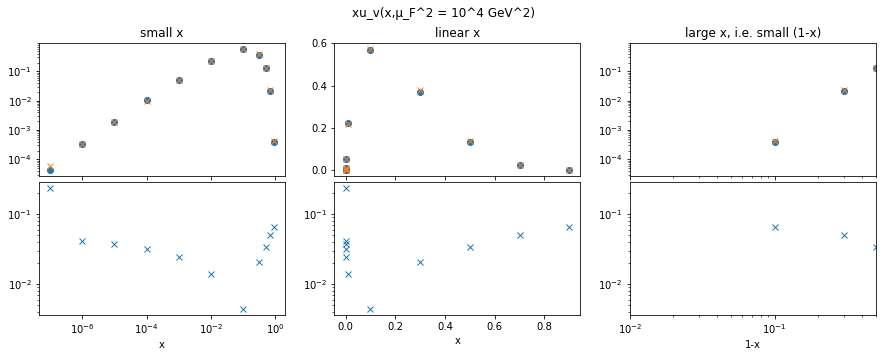

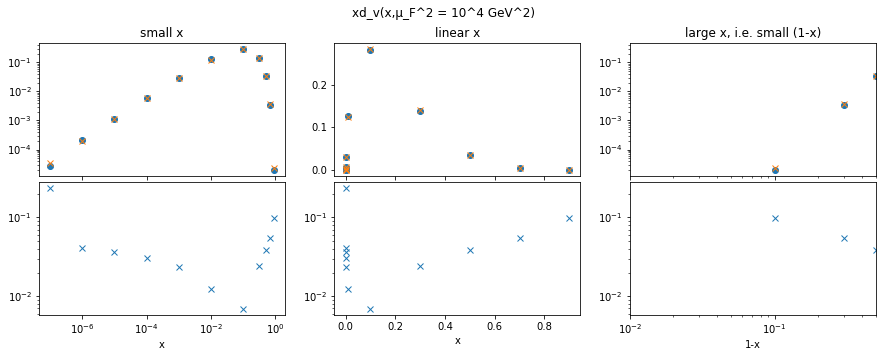

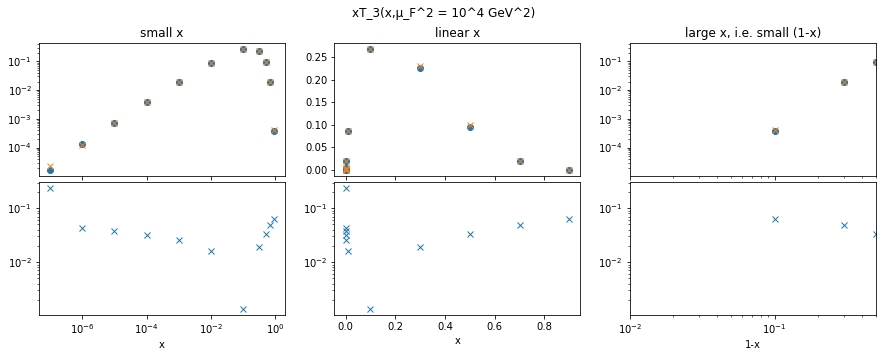

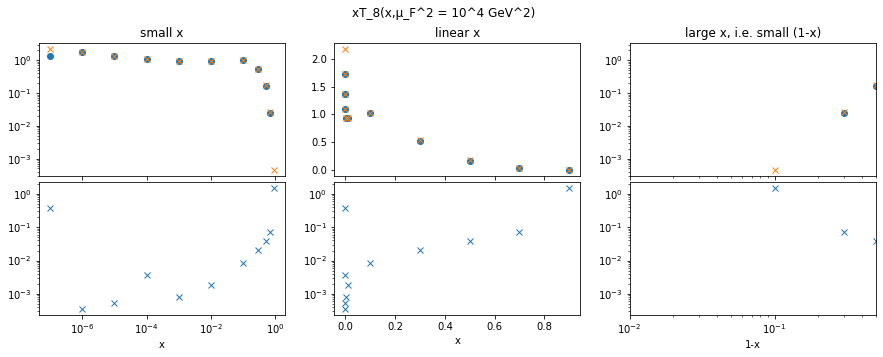

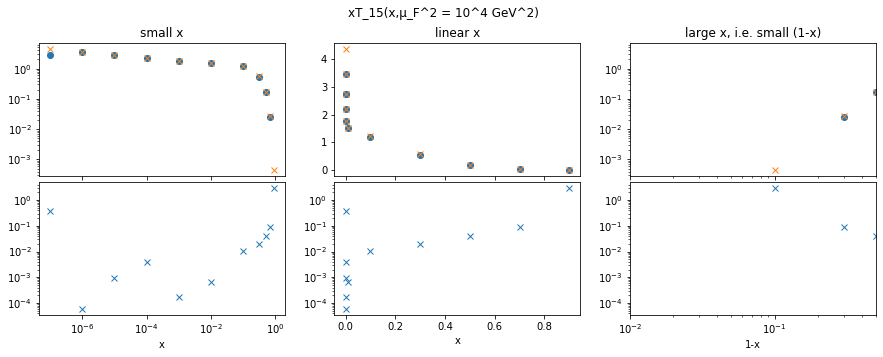

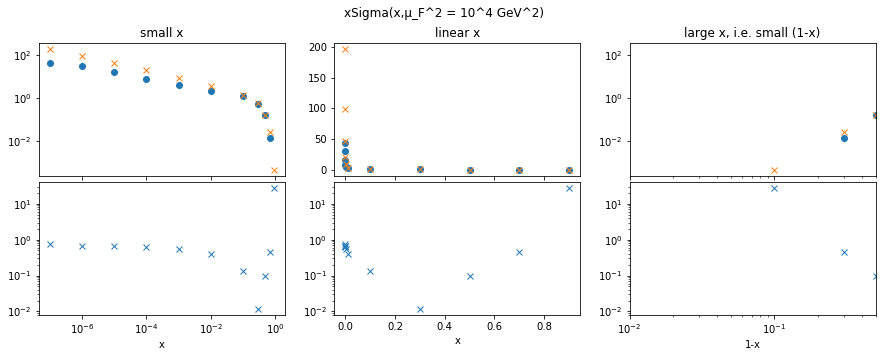

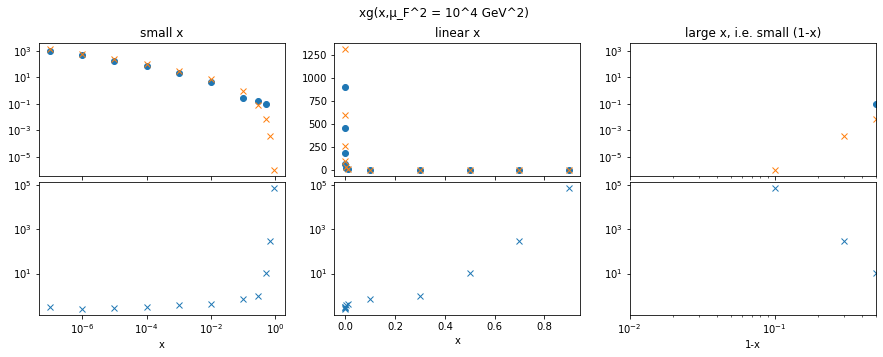

In [54]:
# Now we have to define the dot operation, which is highly non trivial... 
def dot_me(ops1, ops2):
    res = {}
    for key, item in ops1.items():
        op1 = item[:,:,0]
        op2 = ops2[key][:,:,0]
        op3 = np.dot(op2, op1).reshape(op2.shape[0], op2.shape[1], 1)
        res[key] = op3
    return res
xtozz = dot_me(xtoy["operators"], ytoz["operators"])
plot_table2_2(xtozz)

In [55]:
qfort = 80.0
ytot = dglap.run_dglap({
    "PTO": 0,
    'alphas': 0.35,
    'Qref': Qref,
    'Q0': qfory,
    'NfFF': nf,

    "xgrid_type": "custom",
    "xgrid": xgrid,
    "xgrid_polynom_rank": polynom_rank,
    "log_interpol": True,
    "targetgrid": xgrid,
    "Q2grid": [pow(qfort,2)],
    "jobs" : -1
})

In [56]:
ttoz = dglap.run_dglap({
    "PTO": 0,
    'alphas': 0.35,
    'Qref': Qref,
    'Q0': qfort,
    'NfFF': nf,

    "xgrid_type": "custom",
    "xgrid": xgrid,
    "xgrid_polynom_rank": polynom_rank,
    "log_interpol": True,
    "targetgrid": toy_xgrid,
    "Q2grid": [1e4],
    "jobs" : -1
})

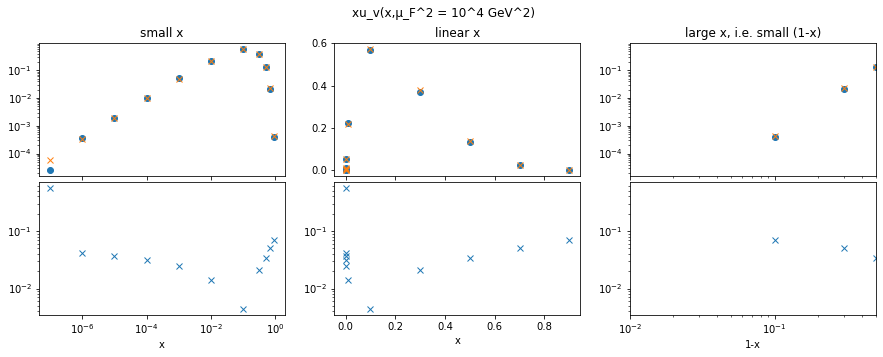

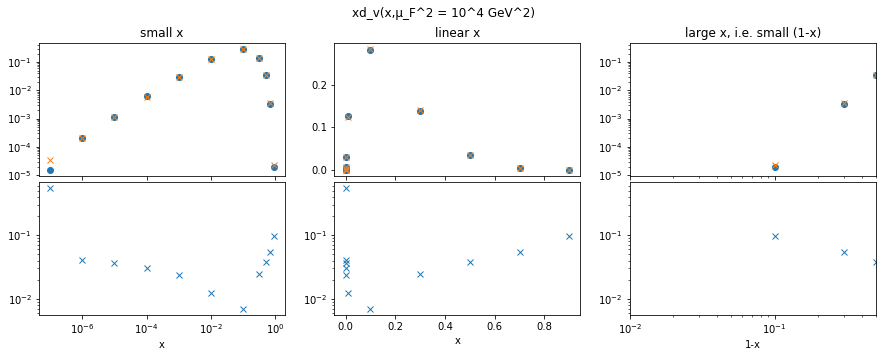

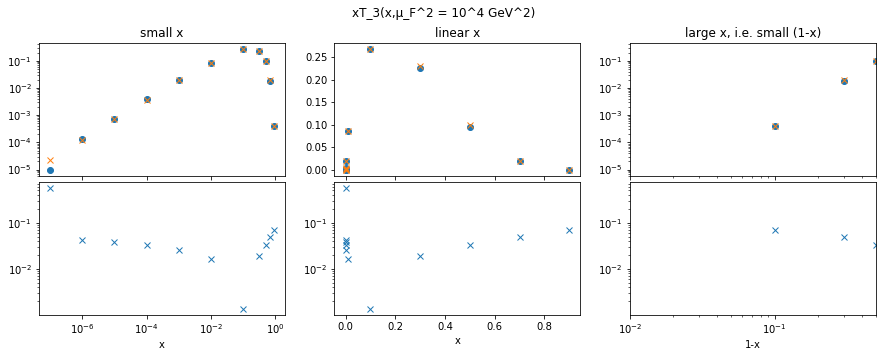

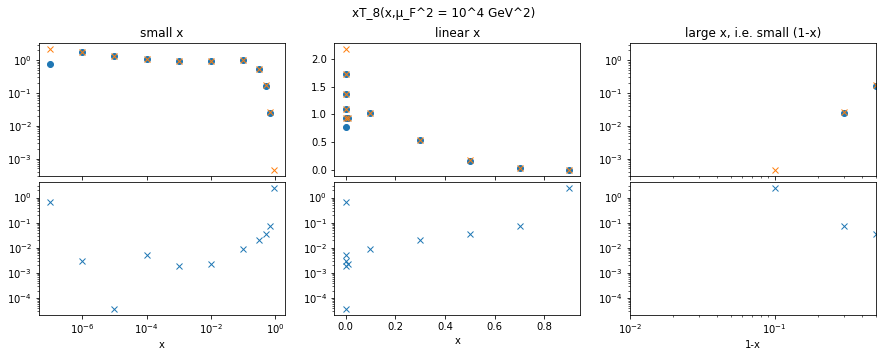

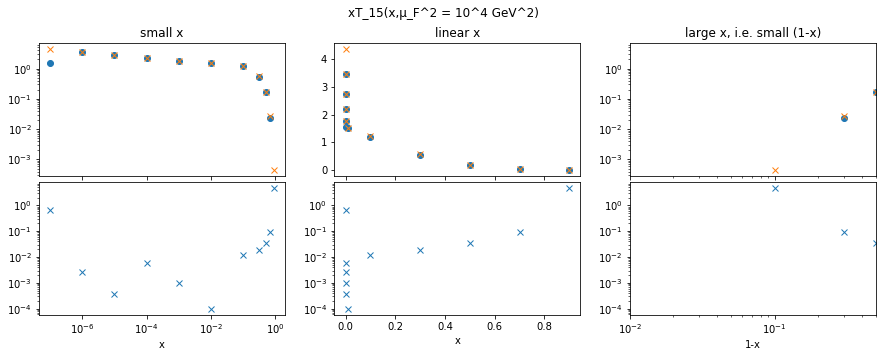

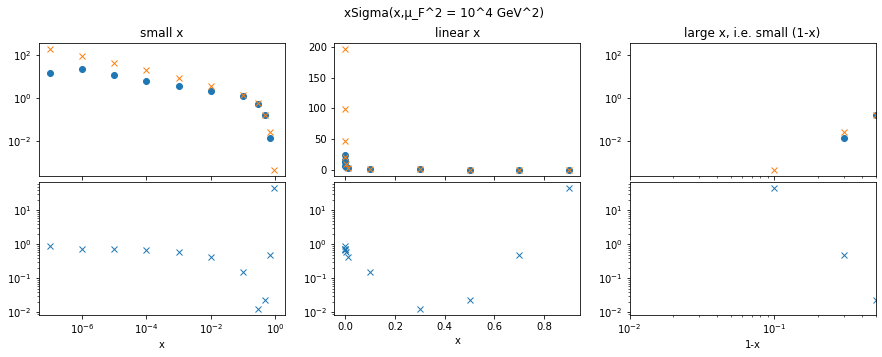

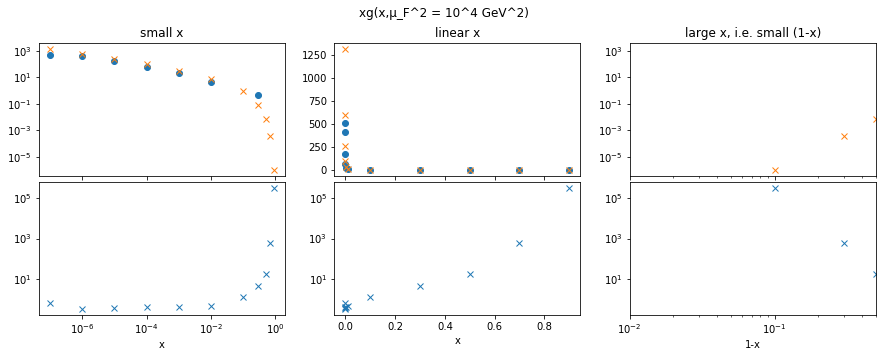

In [57]:
xtot = dot_me(xtoy["operators"], ytot["operators"])
xtoz = dot_me(xtot, ttoz["operators"])
plot_table2_2(xtoz)

In [216]:
import lhapdf
pdf = lhapdf.mkPDF("NNPDF31_lo_as_0118",0)
q1 = pow(6.2897452,2)
qgrid = np.array([4.4756282e+01, 5.5191298e+01, 6.8637940e+01, 8.6115921e+01, 1.0903923e+02, 1.3938725e+02, 1.7995815e+02, 2.3474820e+02, 3.0952544e+02, 4.1270732e+02, 5.5671861e+02])
q2grid = np.power(qgrid, 2)
qf = q2grid[0]
alpha_s = pdf.alphasQ2(q1)

5

In [204]:
%%time

evol_op = dglap.run_dglap({
    "PTO": 0,
    'alphas': alpha_s,
    'Qref': np.sqrt(q1),
    'Q0': np.sqrt(q1),
    'NfFF': nf,

    "xgrid_type": "custom",
    "xgrid": xgrid,
    "xgrid_polynom_rank": polynom_rank,
    "log_interpol": True,
    "targetgrid": toy_xgrid,
    "Q2grid": q2grid,
    "jobs" : -1
})

CPU times: user 4.63 s, sys: 4.39 s, total: 9.02 s
Wall time: 12min 58s


In [272]:
index = 3
qtest = q2grid[index]
def get_pdf(q, grid):
    q_dict = []
    singlet_res = []
    gluon_res = []
    for x in grid:
        pdf_q = pdf.xfxQ2(x, q)
        pdf_q["s"] = np.sum([pdf_q[i]+pdf_q[-i] for i in range(1,6)])
        q_dict.append(pdf_q)
        singlet_res.append(pdf_q["s"]/x)
        gluon_res.append(pdf_q[21]/x)
    return q_dict, np.array(singlet_res), np.array(gluon_res)

q1_list, s1, g1 = get_pdf(q1, xgrid)
qf_list, sf, gf = get_pdf(qtest, toy_xgrid)

In [286]:
ytoz_gg = evol_op["operators"]["S_gg"][:,:,index]
ytoz_gq = evol_op["operators"]["S_gq"][:,:,index]
print((np.dot(ytoz_gg, g1)+np.dot(ytoz_gq, s1)))
print(gf)
def digest(numbers):
    return [f"{abs(100*i):2.2f}" for i in numbers]
print(digest((np.dot(ytoz_gg, g1)+np.dot(ytoz_gq, s1)-gf)/gf))
print(np.dot(evol_op["operator_errors"]["S_gg"][:,:,index], g1))

[ 1.24301580e+10  5.80677028e+08  2.56459389e+07  1.02906537e+06
  3.50450273e+04  8.69514481e+02  8.72606132e+00  2.58474389e-01
  1.83759368e-02 -1.62149717e-02  2.21461954e-03]
[1.24510875e+10 5.79569748e+08 2.55861404e+07 1.02640964e+06
 3.49723773e+04 8.66551226e+02 8.75803550e+00 2.45171510e-01
 9.85921557e-03 3.37094495e-04 6.65423558e-06]
['0.17', '0.19', '0.23', '0.26', '0.21', '0.34', '0.37', '5.43', '86.38', '4910.22', '33181.35']
[2.33800303 0.0506125  0.00387298 0.00331063 0.00398078 0.00286825
 0.00423737 0.00430391 0.00403507 0.00408416 0.00432028]


In [275]:
ytoz_qg = evol_op["operators"]["S_qg"][:,:,index]
ytoz_qq = evol_op["operators"]["S_qq"][:,:,index]
print(np.dot(ytoz_qg, g1)+np.dot(ytoz_qq, s1))
print(sf)
print(digest((np.dot(ytoz_qg, g1)+np.dot(ytoz_qq, s1)-sf)/sf))

[ 2.29651852e+09  1.13525323e+08  5.46715558e+06  2.58517031e+05
  1.12246138e+04  4.08249697e+02  1.34208439e+01  1.80528955e+00
  3.05338550e-01  2.14832196e-02 -3.01880376e-03]
[2.23181899e+09 1.11328050e+08 5.45938372e+06 2.58155227e+05
 1.09824670e+04 4.07121547e+02 1.35119325e+01 1.77187995e+00
 3.10250483e-01 3.30175332e-02 1.31863170e-03]


ValueError: operands could not be broadcast together with shapes (49,) (11,) 